In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


## Functions

In [2]:
#Process data

def get_lognorm(df, cols = ['Reads'], new_col = ''):
    '''
    Inputs: 
    1. df: clean reads dataframe
    2. cols: list of names of column containing data used to calculate lognorm (default = ['Reads'])
    3. new_col: lognorm column name (optional) 
    Output: New dataframe with columns 'Gene Symbol', '[col]_Lognorm' (default = 'Reads_lognorm')
    '''
    df_lognorm = df.copy().drop(cols, axis = 1)
    for c in cols:
        df_lognorm[c+'_lognorm'] = pool.lognorm(df[c])
    return df_lognorm 


In [3]:
#QC 

def calculate_lfc(lognorm_df, target_cols, ref_col = 'pDNA_lognorm'): 
    '''
    Inputs:
    1. lognorm_df: Dataframe containing reference and target lognorm columns 
    2. target_cols: List containing target column name(s) (lognorm column(s) for which log-fold change should be calculated)
    3. ref_col: Reference column name (lognorm column relative to which log-fold change should be calculated)(default ref_col = 'pDNA_lognorm')
    '''
    #input df with lognorms + pDNA_lognorm
    lfc_df = pool.calculate_lfcs(lognorm_df=lognorm_df,ref_col='pDNA_lognorm', target_cols=target_cols)
    for col in target_cols: #rename log-fold change column so doesn't say "lognorm"
        if 'lognorm' in col:
            lfc_col_name = col.replace('lognorm', 'lfc') 
        else:
            lfc_col_name = col + '_lfc'
        lfc_df = lfc_df.rename(columns = {col:lfc_col_name})
    return lfc_df

def get_controls(df, control_name = ['Non-Targeting'], separate = True):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls (default: 'NO_SITE', 'ONE_INTERGENIC')
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0])]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl)]
        if separate: 
            return control_dict
        else:
            all_controls = pd.concat(list(control_dict.values()))
            return all_controls

def merge_pDNA_lognorm(pDNA_reads, lognorm): #lognorm pDNA reads and merge with lognorm df
    '''
    Inputs:
    1. pDNA_reads: data frame containing pDNA reads
    2. lognorm: data frame containing log-normalized data 
    Output: all_lognorms: merged data frame with pDNA lognorms and data lognorms 
    '''
    pDNA_lognorm = fns.get_lognorm(pDNA_reads.copy(), ['pDNA'])
    pDNA_lognorm = pDNA_lognorm.copy().rename(columns = {'sgRNA Sequence': 'Construct Barcode'})
    #pDNA_lognorm = pDNA_lognorm.copy().drop('pDNA', axis = 1)
    lognorm = lognorm.copy().drop(['Construct IDs', 'EMPTY'], axis = 1)
    all_lognorms = pd.merge(pDNA_lognorm, lognorm, on = 'Construct Barcode', how = 'inner')
    return all_lognorms 

def merge_chip_lfc(chip, lfc):
    '''
    Inputs: 
    1. chip: guide-gene annotations data frame
    2. lfc: data frame containing log-fold change (lfc) values (relative to pDNA) 
    Outputs: 
    chip_lfc: merged dataframe with lfc values and gene annotations 
    '''
    chip = chip.rename(columns = {'Barcode Sequence': 'Construct Barcode'})
    chip_lfc = pd.merge(chip, lfc, on = 'Construct Barcode', how = 'inner')
    chip_lfc = chip_lfc.drop('Gene ID', axis = 1)
    return chip_lfc

def process_chip(chip):
    '''
    Input: chip: guide-gene annotation data frame 
    Output: chip: Reformatted guide-gene annotation data frame 
    '''
    if 'Barcode Sequence' in chip.columns:
        chip = chip.rename(columns ={'Barcode Sequence':'Construct Barcode'})
    if 'Gene ID' in chip.columns:
        chip = chip.drop('Gene ID', axis =1)
    return chip

In [4]:
## Plotting functions
def group_cols(df, initial_id = 'initial', res_id = 'resistant', sep = ' ', col_type = 'lfc'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    3. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    4. sep: character separator in column name 
    5. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    Outputs: 
    1. sharex: if number of pairs greater than 1 indicating multiple subplots
    2. pairs: pairs of initial and resistant populations as list of lists     
    '''
    
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    sharex = False
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split(sep)
                #print(split_col)
                ini_index = split_col.index(initial_id)
                res_col_string = ' '.join(split_col[:ini_index-1])
                if 'screen' in col: 
                    screen_index = split_col.index('screen')
                    screen = split_col[screen_index]
                    number = split_col[screen_index+1]
                    if '/' in number: # if. inital pop corresponds to multiple res pop
                        number_list = number.split('/')
                        screen_str_list = []
                        res_pop_list = []
                        for number in number_list:
                            screen_str = screen + ' ' + number
                            screen_str_list.append(screen_str)
                        for screen_str in screen_str_list:
                            res_pop_check1 = [col for col in cols if (res_col_string in col) and (res_id in col)]
                            res_pop = []
                            for res_col in res_pop_check1:
                                #check if either screen string in res_col
                                if any(string in res_col for string in screen_str_list):
                                    res_pop.append(res_col)
                                    #print(res_pop)

                    else:
                        screen_str = screen + ' ' + number 
                        res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and (screen_str in col)]
                else:
                    res_pop = [col for col in cols if (res_col_string in col) and (res_id in col) and ('screen' not in col)]
                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        if len(pairs) > 1:
            sharex = True # set sharex parameter for subplot 
        return sharex, pairs

    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs
    
def lfc_dist_plot(chip_lfc, initial_id = 'initial', res_id = 'resistant', target_cols=None, ref_col=None, ref_map = None, filename = '', figsize = (6,4)): #kde plots of population distribution (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        2. ref_map: Dataframe with two columns: 
                    -'initial': (string) name of column containing log-fold changes of uninfected population
                    -'resistant': list name(s) of column(s) containing log-fold changes of infected population
                        --> if there's more than one resistant population corresponding to the same initial population,
                            store as list in same cell 
                            
    Outputs: kde plots of population distribution (initial, resistant)
    '''
        
    if not ref_map:
        sharex, lfc_pairs = group_cols(chip_lfc, initial_id = initial_id, res_id = res_id)
    #else:
    #print(sharex)
    fig, ax = plt.subplots(nrows = len(lfc_pairs), ncols = 1, sharex = sharex, figsize = figsize)
    
    #screen = get_df_name(chip_lfc).split('_')[-2:]
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs):
        
        for l, c1 in enumerate(c):
            #title ex. Calu-3 Calabrese A screen 1, (k+1 = screen #)
            if not filename:
                title = ' '.join(c1.split(' ')[:3]) + ' (populations)'
            else:
                title = filename
            if l==0:
                label1 = c1
            else:
                #label1 = 'Resistant population-'+str(l)
                label1 = c1
                
            if sharex: #if multiple axes, ax = ax[i]
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
                t = ax[i].set_xlabel('Log-fold changes') 
                t = ax[i].set_title(title)
                ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            else: 
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax, legend=True)
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        i+=1
        sns.despine()   
    filepath = '../../Figures/' + filename + '_popdist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    
#Control distributions
def control_dist_plot(chip_lfc, control_name = [], initial_id = 'initial', res_id = 'resistant', filename = '', figsize = (6,4)): #kde plots of control distributions (initial, resistant)
    '''
    Inputs: 
    1. chip_lfc: annotated lfc data frame
    2. control_name: list containing strings identifying controls 
    3. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    4. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    5. filename: filename for saving figure
    6. figsize: default (6, 4)
    Outputs: kde plots of control distributions (initial, resistant)
    
    '''
    sharex, lfc_pairs = group_cols(chip_lfc, initial_id= initial_id, res_id=res_id)
    #nosite, intergenic = get_controls(chip_lfc)
    control_dict = {}
    if len(control_name) == 1:
        controls = get_controls(chip_lfc, control_name)
    else:
        control_dict = get_controls(chip_lfc, control_name)
        all_controls = get_controls(chip_lfc, control_name, separate = False)
#         print(all_controls)
    nrows = len(lfc_pairs)
    #print(nrows)
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)
    #print(nrows)
    #screen = get_df_name(chip_lfc).split('_')[-2:]
    i = 0 # ax index if have to plot multiple axes
    if control_dict: 
        for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
            #print(k, c)
            for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
    
                    title = c1 + ' (controls)'
                    #pop_label = ' '.join(c1.split(' ')[1:4]) #labels 'initial' or 'resistant'
                    pop_label = c1
                    #Plot same screen on same subplot 
                    if sharex: #if multiple axes, ax = ax[i]
                        #print(i)
                        for key, df in control_dict.items():
                            df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= key + ' ('+pop_label+')', ax=ax[i], legend=True)
                        all_controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='All controls ('+pop_label+')', ax=ax[i], linestyle='dotted', legend=True)
                        ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                        sns.despine()
                        t = ax[i].set_xlabel('Log-fold changes')
                        t = ax[i].set_title(title)
                        
                    else: 
                        for key, df in control_dict.items():
                            df[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= key + ' ('+pop_label+')', ax=ax, legend=True)
                        all_controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Controls ('+pop_label+')', ax=ax, linestyle='dotted', legend=True)
                        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                        sns.despine()
                        t = ax.set_xlabel('Log-fold changes')
                        t = ax.set_title(title)
            i+=1 #switch to next subplot for next screen
    else:
        for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
            for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
                title = c1 + ' (controls)'
                #pop_label = ' '.join(c1.split(' ')[1:4]) #labels 'initial' or 'resistant'
                pop_label = c1
                #Plot same screen on same subplot 
                if sharex: #if multiple axes, ax = ax[i]
                    controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= control_name[0] + '('+pop_label+')', ax=ax[i], legend=True)
                    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    sns.despine()
                    t = ax[i].set_xlabel('Log-fold changes')
                    t = ax[i].set_title(title)
                else: 
                    controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label= control_name[0] + '('+pop_label+')', ax=ax, legend=True)
                    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                    sns.despine()
                    t = ax.set_xlabel('Log-fold changes')
                    t = ax.set_title(title)
            i+=1 #switch to next subplot for next screen

        sns.despine()
    #filename = '_'.join(screen) #get screen name and library and join with _
    filepath = '../../Figures/' + filename + '_controldist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')


In [5]:
from scipy import stats

def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
    paired_lfc_cols = group_cols(lfc_df)[1] #get lfc pairs
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots



## Data Summary

* Cell line: Calu-3
* Library: Calabrese Set A and B

In [6]:
# Read counts data
#Screen 1
reads_screen1_CalSetA = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/counts-JD_GPP2166_Goujon.txt', sep = '\t')
#Screen 2 - Calabrese A 
reads_screen2_CalSetA = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/counts-JD_GPP2205_Goujon_12082020_Plate1.txt', sep = '\t')
#Screen 2 - Calabrese B
reads_screen2_CalSetB = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/counts-JD_GPP2206_Goujon_12082020_Plate2.txt', sep = '\t')

reads_CalSetA = pd.merge(reads_screen1_CalSetA, reads_screen2_CalSetA, on = ['Construct Barcode', 'Construct IDs'], how='outer')


In [7]:
#Read lognorm data
#Screen 1
lognorm_screen1_CalSetA = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/lognorm-JD_GPP2166_Goujon.txt', sep = '\t')
#Screen 2 - Calabrese A 
lognorm_screen2_CalSetA = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/lognorm-JD_GPP2205_Goujon_12082020_Plate1.txt', sep = '\t')
#Screen 2 - Calabrese B
lognorm_screen2_CalSetB = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/lognorm-JD_GPP2206_Goujon_12082020_Plate2.txt', sep = '\t')

#Read Calabrese Set A and B pDNA reads from Sanson et al. 2018
pDNA_reads_CalSetA = pd.read_excel('../../Data/Reads/Goujon/Calu3/Calabrese/CalabreseSetApDNAReads.xlsx', sheet_name= 'SetA pXPR_109 raw reads', header = 3)
pDNA_reads_CalSetA = pDNA_reads_CalSetA.copy()[['sgRNA Sequence', 'pDNA']]
pDNA_reads_CalSetB = pd.read_excel('../../Data/Reads/Goujon/Calu3/Calabrese/CalabreseSetApDNAReads.xlsx', sheet_name= 'SetB pXPR_109 raw reads', header = 2)
pDNA_reads_CalSetB = pDNA_reads_CalSetB.copy()[['sgRNA Sequence', 'pDNA']]


In [8]:
#Lognorm pDNA reads, merge with lognorms values from screen
#Screen 1, Calabrese Set A
all_lognorms_screen1_CalSetA = merge_pDNA_lognorm(pDNA_reads_CalSetA, lognorm_screen1_CalSetA)
#Screen 2, Calabrese Set A
all_lognorms_screen2_CalSetA = merge_pDNA_lognorm(pDNA_reads_CalSetA, lognorm_screen2_CalSetA)
#Screen 2, Calabrese Set B
all_lognorms_screen2_CalSetB = merge_pDNA_lognorm(pDNA_reads_CalSetB, lognorm_screen2_CalSetB)

## QC

In [9]:
#calculate lfc relative to pDNA 
#Screen 1, Calabrese Set A
lfc_screen1_CalSetA = calculate_lfc(all_lognorms_screen1_CalSetA, all_lognorms_screen1_CalSetA.columns[2:].to_list())
#Screen 2, Calabrese Set A
lfc_screen2_CalSetA = calculate_lfc(all_lognorms_screen2_CalSetA, all_lognorms_screen2_CalSetA.columns[2:].to_list())
#Screen 2, Calabrese Set B
lfc_screen2_CalSetB = calculate_lfc(all_lognorms_screen2_CalSetB, all_lognorms_screen2_CalSetB.columns[2:].to_list())

In [10]:
#merge lfc with chip file
CalSetA_chip = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/CP0052_GRCh38_NCBI_strict_gene_20200612.chip', sep = '\t')
CalSetB_chip = pd.read_csv('../../Data/Reads/Goujon/Calu3/Calabrese/CP0053_GRCh38_NCBI_strict_gene_20201123.chip', sep = '\t')

#Screen 1, Calabrese Set A
chip_lfc_screen1_CalSetA = merge_chip_lfc(CalSetA_chip, lfc_screen1_CalSetA)

#Screen 2, Calabrese Set A
chip_lfc_screen2_CalSetA = merge_chip_lfc(CalSetA_chip, lfc_screen2_CalSetA)

#merge Calabrese Set A screens
chip_lfc_CalSetA = pd.merge(chip_lfc_screen1_CalSetA, chip_lfc_screen2_CalSetA, on = ['Construct Barcode', 'Gene Symbol'], how = 'inner')

#Screen 2, Calabrese Set B
chip_lfc_screen2_CalSetB = merge_chip_lfc(CalSetB_chip, lfc_screen2_CalSetB)


../../Figures/CalabreseSetA_popdist.png
../../Figures/CalabreseSetB_popdist.png


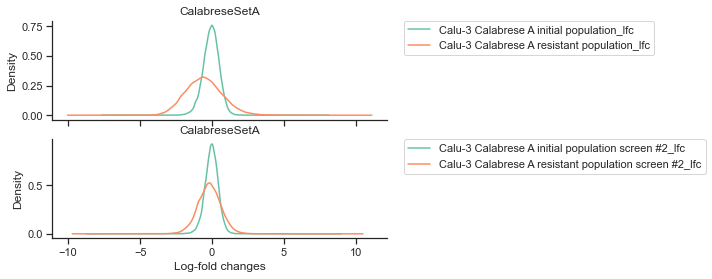

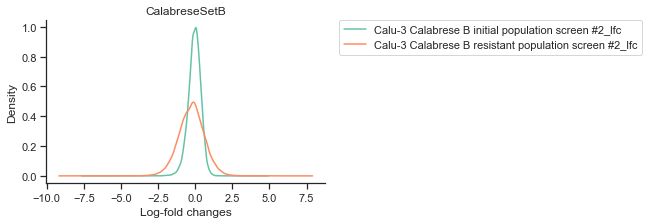

In [11]:
#Population distributions for each screen
#Calabrese Set A
#lfc_dist_plot_screen1_CalSetA = lfc_dist_plot(chip_lfc_screen1_CalSetA)
#lfc_dist_plot_screen2_CalSetA = lfc_dist_plot(chip_lfc_screen2_CalSetA)
lfc_dist_plot_CalSetA = lfc_dist_plot(chip_lfc_CalSetA, filename='CalabreseSetA')

#Screen 2, Calabrese Set B
lfc_dist_plot_screen2_CalSetB = lfc_dist_plot(chip_lfc_screen2_CalSetB, filename='CalabreseSetB', figsize = (5,3))


../../Figures/CalabreseSetA_controldist.png
../../Figures/CalabreseSetB_controldist.png


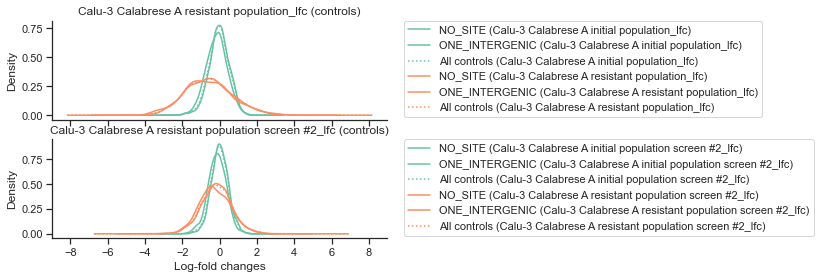

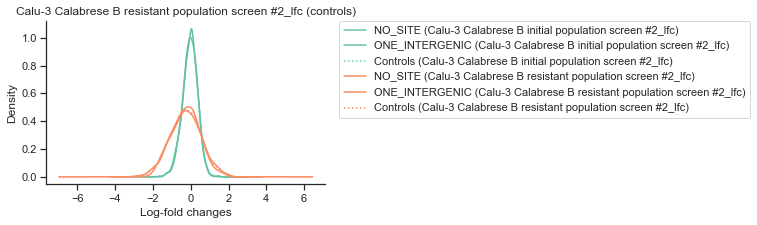

In [12]:
#Control distributions
#Calabrese Set A
control_dist_plot_CalSetA = control_dist_plot(chip_lfc_CalSetA, control_name=['NO_SITE', 'ONE_INTERGENIC'], filename = 'CalabreseSetA')
#Screen 2, Calabrese Set B
control_dist_plot_screen2_CalSetB= control_dist_plot(chip_lfc_screen2_CalSetB, control_name=['NO_SITE', 'ONE_INTERGENIC'], filename = 'CalabreseSetB', figsize=(5,3))


## Residual z-scores

In [13]:
CalSetA_chip  = process_chip(CalSetA_chip)
CalSetA_chip = pool.group_pseudogenes(CalSetA_chip, pseudogene_size=3, gene_col = 'Gene Symbol', control_regex = ['ONE_INTERGENIC', 'NO_SITE'])
CalSetB_chip = process_chip(CalSetB_chip)
CalSetB_chip = pool.group_pseudogenes(CalSetB_chip, pseudogene_size=3, gene_col = 'Gene Symbol', control_regex = ['ONE_INTERGENIC', 'NO_SITE'])
CalSetA_B_chip = pd.concat([CalSetA_chip, CalSetB_chip])

#guide residuals: Calabrese Set A
lfc_CalSetA = pd.merge(lfc_screen1_CalSetA, lfc_screen2_CalSetA, on = 'Construct Barcode', how = 'inner')
CalSetA_guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_CalSetA)
#guide residuals: Calabrese Set B
CalSetB_guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_screen2_CalSetB)

#concatenate guide_residuals df -->input for gene_residuals, concat chip file 
CalSetA_B_guide_residuals_lfcs = pd.concat([CalSetA_guide_residuals_lfcs, CalSetB_guide_residuals_lfcs])
CalSetA_B_gene_residuals = anchors.get_gene_residuals(CalSetA_B_guide_residuals_lfcs, CalSetA_B_chip)
CalSetA_B_gene_residuals


                                            modified  \
0        Calu-3 Calabrese A resistant population_lfc   
1  Calu-3 Calabrese A resistant population screen...   

                                         unperturbed  
0          Calu-3 Calabrese A initial population_lfc  
1  Calu-3 Calabrese A initial population screen #...  
                                            modified  \
0  Calu-3 Calabrese B resistant population screen...   

                                         unperturbed  
0  Calu-3 Calabrese B initial population screen #...  


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu-3 Calabrese A resistant population screen...,A1BG,3,-0.020894,-0.070971,0.498464,0.618157,0.994032
1,Calu-3 Calabrese A resistant population screen...,A1BG-AS1,2,0.160234,-0.204598,1.020416,0.307531,0.994032
2,Calu-3 Calabrese A resistant population screen...,A1CF,3,-0.226157,0.187073,-0.599357,0.548935,0.994032
3,Calu-3 Calabrese A resistant population screen...,A2M,3,-0.009272,0.403773,-0.543448,0.586821,0.994032
4,Calu-3 Calabrese A resistant population screen...,A2ML1,3,-0.663674,-0.124923,-0.998749,0.317916,0.994032
...,...,...,...,...,...,...,...,...
65329,Calu-3 Calabrese B resistant population screen...,ZYG11A,3,0.017097,0.135014,0.199698,0.841717,0.997439
65330,Calu-3 Calabrese B resistant population screen...,ZYG11B,3,0.395540,-0.080945,1.543328,0.122751,0.990341
65331,Calu-3 Calabrese B resistant population screen...,ZYX,3,-1.125051,-0.499163,-1.016311,0.309481,0.997439
65332,Calu-3 Calabrese B resistant population screen...,ZZEF1,3,-0.266508,-0.082765,0.034252,0.972676,0.999651


In [14]:
gene_residual_sheet = fns.format_gene_residuals(CalSetA_B_gene_residuals, guide_min=2, guide_max=4, ascending=True)
gene_residual_sheet
guide_residual_sheet = pd.merge(CalSetA_B_chip, CalSetA_B_guide_residuals_lfcs, on = 'Construct Barcode', how = 'outer')

['Calu-3 Calabrese B resistant population screen #2_lfc', 'Calu-3 Calabrese A resistant population_lfc', 'Calu-3 Calabrese A resistant population screen #2_lfc']
Calu-3 Calabrese B resistant population screen #2_lfc
Calu-3 Calabrese A resistant population_lfc
Calu-3 Calabrese A resistant population screen #2_lfc


In [15]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Calu3_Calabrese_Goujon_v3.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_Calabrese_avg_zscore', index =False)
    reads_CalSetA.to_excel(writer, sheet_name='Calu3_CalSetA_genomewide_reads', index =False)
    reads_screen2_CalSetB.to_excel(writer, sheet_name='Calu3_CalSetB_genomewide_reads', index =False)
    CalSetA_B_chip.to_excel(writer, sheet_name='Calu3_Calabrese_guide_mapping', index =False)

In [16]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Calu3_Calabrese_Goujon_indiv_v3.xlsx') as writer:   
    CalSetA_B_gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)